# **Assignment 3: Stress recognition**
#### Yuna Watanabe

## **Data structure**
The data used are included in `./data/WESAD/` repository. 

## **Import libraries**

In [1]:
import flirt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import pickle
from tqdm import tqdm
from sys import path
path.append('heartview/pipeline/')
import PPG

/Users/yuna.w/2024/fall/hinf5300/.venv/lib/python3.12/site-packages/flirt/acc/feature_calculation.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


## **Load and preprocess data**

Although the `flirt.simple.get_features_for_empatica_archive()` function can be simply used to extract features, I decided to use pickle file data to synchronize labels. The `quest.csv` file contains time range for each condition, but this time is the elapsed time since the start of the RespiBAN device. Because time clock of Empatica E4 and RespiBAN was not synchronized and the start time of the recordings should also differ, the pickle file is the only way to exactly match the labels.

In [2]:
data_dir = './data/WESAD/'
pids = os.listdir(data_dir)
pids = [dir for dir in pids if dir[0] == 'S']
pids

['S5',
 'S2',
 'S3',
 'S4',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [3]:
respiban_fs = 700
bvp_fs = 64
eda_fs = 4

I firstly extracted label, BVP, and EDA data from the pickle files for each participant. Pickle file does not contain IBI data from the E4 device, so I performed signal filtering and beat detection for the BVP signals to obtain IBI data. Here, I used the heartview package to implement simple filtering and beat detection. The package modules are located in the `./heartview/` directory.

Although I don't need timestamps to extract features or match labels, the flirt package requires a Series with datetime indices. Therefore, I conveniently set the first time as 2023-01-01 00:00:00 and calculated corresponding timestamps based on the sampling frequency.

> Ref: Yamane, N., Mishra, V., & Goodwin, M. S. (2024). HeartView: An Extensible, Open-Source, Web-Based Signal Quality Assessment Pipeline for Ambulatory Cardiovascular Data. Pervasive Computing Technologies for Healthcare, 107–123.
> https://heartview.readthedocs.io/en/latest/

In [4]:
first_time = pd.to_datetime('2023-01-01 00:00:00')
df_dict = {}

for pid in tqdm(pids):
    df_dict[pid] = {}
    # Load the pickle data
    with open(f'{data_dir}{pid}/{pid}.pkl', 'rb') as f:
        pkldata = pickle.load(f, encoding = 'latin1')

    # Get the label data
    df_label = pd.DataFrame(pkldata['label'], columns=['label'])
    # Calculate the cumulative seconds for each row
    cum_seconds_label = np.arange(len(pkldata['label'])) / respiban_fs
    df_label['cum_seconds'] = cum_seconds_label
    # Calculate the timestamp for each row
    df_label['timestamp'] = first_time + pd.to_timedelta(cum_seconds_label, unit='s')
    df_label = df_label.drop(columns='cum_seconds')
    df_dict[pid]['label'] = df_label

    # Get the BVP data
    df_bvp = pd.DataFrame(pkldata['signal']['wrist']['BVP'], columns=['BVP'])
    # Calculate the cumulative seconds for each row
    cum_seconds_bvp = np.arange(len(pkldata['signal']['wrist']['BVP'])) / bvp_fs
    df_bvp['cum_seconds'] = cum_seconds_bvp
    # Filter the BVP signal
    PPGFilter = PPG.Filters(fs=bvp_fs)
    df_bvp['Filtered'] = PPGFilter.filter_signal(df_bvp['BVP'])
    # Detect peaks in the BVP signal
    BeatDetector = PPG.BeatDetectors(fs=bvp_fs, preprocessed=True)
    peak_ix = BeatDetector.adaptive_threshold(df_bvp['Filtered'])
    df_bvp['Peak'] = np.nan
    df_bvp.loc[peak_ix, 'Peak'] = 1
    df_dict[pid]['bvp'] = df_bvp

    # Get the IBI data based on the detected peaks
    df_ibi = pd.DataFrame()
    df_ibi['IBI'] = (df_bvp.loc[df_bvp['Peak'] == 1, 'cum_seconds'].diff() * 1000)
    df_ibi = df_ibi.reset_index(drop=True)
    # Drop the first row since it is NaN
    df_ibi = df_ibi.loc[1:].reset_index(drop=True)
    # Calculate the cumulative IBI
    df_ibi['cum_ibi'] = df_ibi['IBI'].cumsum().shift(fill_value=0)
    # Calculate the timestamp for each row
    df_ibi['timestamp'] = first_time + pd.to_timedelta(df_ibi['cum_ibi'], unit='ms')
    df_ibi = df_ibi.drop(columns='cum_ibi').set_index('timestamp')
    df_dict[pid]['ibi'] = df_ibi

    # Get the EDA data
    df_eda = pd.DataFrame(pkldata['signal']['wrist']['EDA'], columns=['EDA'])
    # Calculate the cumulative seconds for each row
    cum_seconds_eda = np.arange(len(pkldata['signal']['wrist']['EDA'])) / eda_fs
    df_eda['cum_seconds'] = cum_seconds_eda
    # Calculate the timestamp for each row
    df_eda['timestamp'] = first_time + pd.to_timedelta(df_eda['cum_seconds'], unit='s')
    df_eda = df_eda.drop(columns='cum_seconds').set_index('timestamp')
    df_dict[pid]['eda'] = df_eda

100%|██████████| 15/15 [00:53<00:00,  3.55s/it]


Example resulting dataframes are shown below.

In [5]:
df_dict['S2']['label'].head()

,label,timestamp
0,0,2023-01-01 00:00:00.000000000
1,0,2023-01-01 00:00:00.001428571
2,0,2023-01-01 00:00:00.002857143
3,0,2023-01-01 00:00:00.004285714
4,0,2023-01-01 00:00:00.005714286


In [6]:
df_dict['S2']['ibi'].head()

,IBI
timestamp,
2023-01-01 00:00:00.000000,171.875
2023-01-01 00:00:00.171875,1109.375
2023-01-01 00:00:01.281250,875.000
2023-01-01 00:00:02.156250,453.125
2023-01-01 00:00:02.609375,1046.875


In [7]:
df_dict['S2']['eda'].head()

,EDA
timestamp,
2023-01-01 00:00:00.000,1.138257
2023-01-01 00:00:00.250,1.125444
2023-01-01 00:00:00.500,1.011405
2023-01-01 00:00:00.750,1.033188
2023-01-01 00:00:01.000,0.935807


## **Extract features**

Using the `flirt.hrv.get_hrv_features()` and `flirt.eda.get_eda_features()` functions, extract HRV and EDA features. In this assignment, I used window length of 60 seconds and step size of 10 seconds.

When I set `clean_data=True` to extract HRV features, some IBIs were removed from the analysis, which resulted in incompatible time windows between HRV and EDA features. To avoid this, I set `clean_data=False`, which is a limitation of this assignment.

In [8]:
window_length = 60
step_size = 10
features_dict = {}

for pid in pids:
    # Get the HRV features
    features_ibi = flirt.hrv.get_hrv_features(df_dict[pid]['ibi']['IBI'], window_length=window_length, window_step_size=step_size, 
        domains = ['td', 'fd', 'nl', 'stat'], threshold=0.2, clean_data = False)
    # Get the EDA features
    features_eda = flirt.eda.get_eda_features(df_dict[pid]['eda']['EDA'], window_length=window_length, window_step_size=step_size, data_frequency=eda_fs)

    # Merge the features
    features = pd.merge(features_ibi, features_eda, on='datetime', how='inner')

    features_dict[pid] = features

EDA features: 100%|██████████| 626/626 [00:00<00:00, 1093.53it/s]
/Users/yuna.w/2024/fall/hinf5300/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: phasic_entropy contains more than 5% (actual: 66.77%) nan, inf, or -inf values. We recommend to delete this feature column.
  exec(code_obj, self.user_global_ns, self.user_ns)
EDA features: 100%|██████████| 608/608 [00:00<00:00, 1829.87it/s]
/Users/yuna.w/2024/fall/hinf5300/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: tonic_entropy contains more than 5% (actual: 5.76%) nan, inf, or -inf values. We recommend to delete this feature column.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/yuna.w/2024/fall/hinf5300/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: phasic_entropy contains more than 5% (actual: 67.76%) nan, inf, or -inf values. We recommend to delete this feature column.
  exec(code_obj, self.user_global_

## **Sync labels**

In this assignment, I made an assumption that the first timestamps of the BVP/EDA/label data in the pickle files were approximately the same. Although the start time of the BVP/EDA/label data were manually synchronized by the researchers, the sampling frequency of the label data was the same as that of RespiBAN, which required us to synchronize the label data with the Empatica E4 data. Based on the calculated timestamps, I extracted the start and end times of the baseline and stress conditions and labeled the BVP/EDA data accoridng to these timestamps. 

While extracting the features, I got warnings saying that the `tonic_entropy` feature and the `phasic_entropy` contains more than 5% of nan, inf, or -inf values and should be removed. Therefore, I dropped these features from the all dataframes.

In [9]:
features_final_dict = {}
for pid in tqdm(pids):
    df_label = df_dict[pid]['label']
    # Get the start and end timestamps for the baseline and stress conditions
    baseline_start = df_label.loc[df_label['label'] == 1, 'timestamp'].min()
    baseline_end = df_label.loc[df_label['label'] == 1, 'timestamp'].max()
    stress_start = df_label.loc[df_label['label'] == 2, 'timestamp'].min()
    stress_end = df_label.loc[df_label['label'] == 2, 'timestamp'].max()

    features = features_dict[pid]
    # Reset the index because the current index is the datetime
    features = features.reset_index()
    # Add the label column
    features['label'] = np.nan
    # Assign the label values based on the start/end timestamps
    features.loc[(features['datetime'] >= baseline_start) & (features['datetime'] + pd.Timedelta(step_size, unit='s') <= baseline_end), 'label'] = 0
    features.loc[(features['datetime'] >= stress_start) & (features['datetime'] + pd.Timedelta(step_size, unit='s') <= stress_end), 'label'] = 1
    # Drop the rows with NaN label values
    # Drop unnecessary columns
    features = features.loc[(features['label'] == 0) | (features['label'] == 1)].drop(columns=['datetime', 'phasic_entropy', 'tonic_entropy']).reset_index(drop=True)
    features_final_dict[pid] = features

100%|██████████| 15/15 [00:00<00:00, 26.95it/s]


In [10]:
# Concatinate all the feature dataframes
features_final_list = []
for pid in features_final_dict.keys():
    df_id = features_final_dict[pid].copy()
    df_id.loc[:, 'pid'] = pid
    features_final_list.append(df_id)
features_concatinated = pd.concat(features_final_list, ignore_index=True)
features_concatinated

,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,phasic_n_below_mean,phasic_n_sign_changes,phasic_iqr,phasic_iqr_5_95,phasic_pct_5,phasic_pct_95,phasic_perm_entropy,phasic_svd_entropy,label,pid
0,70,858.705357,953.125,1515.625,593.774441,593.791713,66,94.285714,68,97.142857,...,165,3,0.211428,0.430982,0.001030,0.432012,0.999371,0.387109,0.0,S5
1,69,874.320652,968.750,1812.500,616.739584,616.893661,65,94.202899,68,98.550725,...,167,2,0.207020,0.449804,0.000155,0.449960,0.999987,0.377962,0.0,S5
2,69,867.753623,968.750,1796.875,588.593273,588.596906,64,92.753623,68,98.550725,...,131,2,0.500436,0.874872,0.008222,0.883094,0.976122,0.350491,0.0,S5
3,69,870.923913,968.750,1796.875,620.177484,620.179017,63,91.304348,68,98.550725,...,128,1,0.644801,1.043867,0.042754,1.086621,0.968942,0.348044,0.0,S5
4,68,872.242647,1015.625,1796.875,639.087686,639.432249,62,91.176471,67,98.529412,...,126,1,0.493408,1.056365,0.063084,1.119448,0.999987,0.347426,0.0,S5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,73,830.907534,828.125,1984.375,556.060180,556.131361,56,76.712329,60,82.191781,...,124,1,0.020461,0.041084,0.003587,0.044671,0.976122,0.510844,1.0,S15
2718,75,796.875000,812.500,2015.625,459.116215,459.135636,55,73.333333,61,81.333333,...,125,2,0.025961,0.041962,0.002158,0.044119,0.980378,0.502212,1.0,S15
2719,78,775.040064,796.875,2015.625,448.493417,448.493601,54,69.230769,64,82.051282,...,113,2,0.024755,0.049705,0.002032,0.051737,0.978303,0.473927,1.0,S15
2720,78,778.846154,796.875,2015.625,531.032074,531.076891,55,70.512821,66,84.615385,...,110,3,0.031738,0.058208,-0.001704,0.056504,0.994329,0.502194,1.0,S15


## **Standardize data**

Because I used SVM in this assignment, I standardized data before training the model.

In [11]:
scaler = StandardScaler()
# Normalize feature data
features_df_normalized = features_concatinated.copy()
for col in features_df_normalized.columns:
    if (col != 'label') &  (col != 'pid'):
        features_df_normalized[col] = scaler.fit_transform(features_df_normalized[[col]])
features_df_normalized

,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,phasic_n_below_mean,phasic_n_sign_changes,phasic_iqr,phasic_iqr_5_95,phasic_pct_5,phasic_pct_95,phasic_perm_entropy,phasic_svd_entropy,label,pid
0,-0.254373,0.176981,0.797522,0.319001,0.835313,0.835151,1.122834,1.367792,0.801172,1.232929,...,0.265078,1.472934,0.189691,0.178078,-0.192154,0.142207,0.945357,-1.457288,0.0,S5
1,-0.370334,0.343031,0.926890,1.091385,0.965701,0.966308,1.061978,1.363813,0.801172,1.349054,...,0.321284,0.150597,0.178356,0.203474,-0.201844,0.164470,0.950177,-1.523027,0.0,S5
2,-0.370334,0.273199,0.926890,1.050733,0.805896,0.805658,1.001123,1.294179,0.801172,1.349054,...,-0.690422,0.150597,0.932854,0.777002,-0.112475,0.701764,0.763606,-1.720454,0.0,S5
3,-0.370334,0.306911,0.926890,1.050733,0.985220,0.984961,0.940267,1.224544,0.801172,1.349054,...,-0.774731,-1.171741,1.304080,1.005021,0.270130,0.954237,0.707470,-1.738043,0.0,S5
4,-0.486295,0.320934,1.314993,1.050733,1.092585,1.094268,0.879411,1.218400,0.709750,1.347296,...,-0.830937,-1.171741,0.914783,1.021884,0.495368,0.994958,0.950177,-1.742482,0.0,S5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,0.093510,-0.118615,-0.237420,1.538554,0.621184,0.621341,0.514277,0.523429,0.069793,-0.000279,...,-0.887143,-1.171741,-0.301366,-0.347998,-0.163824,-0.338283,0.763606,-0.568034,1.0,S15
2718,0.325432,-0.480510,-0.366787,1.619857,0.070771,0.070663,0.453422,0.361075,0.161215,-0.071086,...,-0.859040,0.150597,-0.287225,-0.346814,-0.179662,-0.338967,0.796873,-0.630070,1.0,S15
2719,0.673315,-0.712698,-0.496155,1.619857,0.010458,0.010245,0.392566,0.163956,0.435482,-0.011868,...,-1.196276,0.150597,-0.290327,-0.336366,-0.181053,-0.329518,0.780653,-0.833348,1.0,S15
2720,0.673315,-0.672225,-0.496155,1.619857,0.479083,0.479098,0.453422,0.225556,0.618327,0.199627,...,-1.280585,1.472934,-0.272371,-0.324894,-0.222445,-0.323605,0.905943,-0.630200,1.0,S15


## **Train classifiers and evaluate performance**

I used SVM as a classifier. Leave-one-subject-out cross validation was implemented.

In [12]:
# Extract features and labels
y = features_df_normalized['label'].values
X = features_df_normalized.drop(columns=['label', 'pid'], inplace=False)

In [13]:
clf = svm.SVC()

# List up all users
pids_list = features_df_normalized['pid']

# Leave one subject out cross validation
logo = LeaveOneGroupOut()

# Train SVM classifier and get predictions
y_pred = cross_val_predict(clf, X, y, cv=logo, groups=pids_list)

In [14]:
# Get classification results
report  = classification_report(y, y_pred, output_dict=True)
accuracy = report['accuracy']
auroc = roc_auc_score(y, y_pred)
report_df = pd.DataFrame(report).drop(columns=['accuracy']).transpose()
print("Accuracy:", accuracy)
print("AUROC:", auroc)
print(tabulate(report_df, headers='keys', tablefmt='pretty', floatfmt=".2f"))

Accuracy: 0.8232916972814107
AUROC: 0.8114263562348034
+--------------+--------------------+--------------------+--------------------+---------+
|              |     precision      |       recall       |      f1-score      | support |
+--------------+--------------------+--------------------+--------------------+---------+
|     0.0      | 0.868144690781797  | 0.8537005163511188 | 0.860862019091698  | 1743.0  |
|     1.0      | 0.7470238095238095 | 0.7691521961184883 | 0.7579265223955712 |  979.0  |
|  macro avg   | 0.8075842501528032 | 0.8114263562348035 | 0.8093942707436346 | 2722.0  |
| weighted avg | 0.8245821107848941 | 0.8232916972814107 | 0.8238400311175951 | 2722.0  |
+--------------+--------------------+--------------------+--------------------+---------+


Text(0.5, 1.0, 'Confusion Matrix (Leave-one-subject-out CV)')

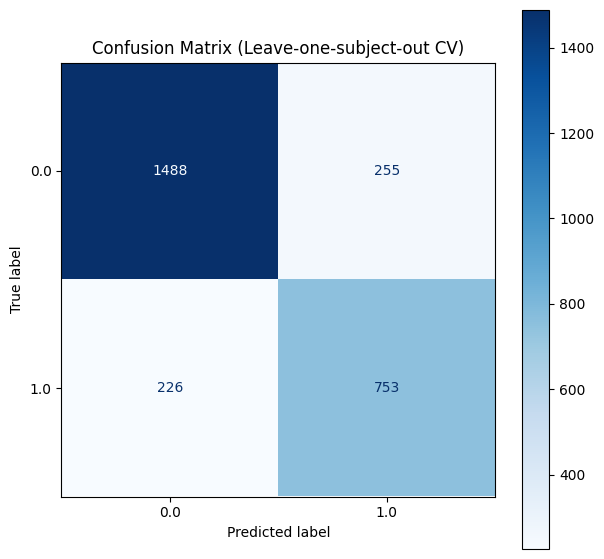

In [15]:
# Get confusion matrix
cm_leave_group_out = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix (Leave-one-subject-out CV)')